In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.lib.display import YouTubeVideo

In [2]:
# log into drive from colab
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# Extract video frame features using an EfficientNet

In [3]:
os.chdir('/content/drive/MyDrive/ITI_Graduation_Project/Video_Captioning/Data')

In [4]:
training_videos_path = os.path.dirname(os.getcwd()) + '/Data/YouTubeClips'
training_videos_path

'/content/drive/MyDrive/ITI_Graduation_Project/Video_Captioning/Data/YouTubeClips'

In [5]:
file_Path, empty_list, filenames = next(os.walk(training_videos_path)) # 1970 videos

In [6]:
print(file_Path)
print(empty_list)
print(filenames[:3])

/content/drive/MyDrive/ITI_Graduation_Project/Video_Captioning/Data/YouTubeClips
[]
['i2sRHf9m5KM_28_42.avi', 'XNzXXiE6qR4_0_10.avi', 'uO7Eysrs8_k_80_90.avi']


In [7]:
working_filenames = [v for v in filenames if not v.startswith(".")] # 1970 videos

In [8]:
# make sure only videos are kept
working_filenames = [v for v in working_filenames if v.endswith(".avi")] # 1970 videos

In [9]:
working_filenames[0]

'i2sRHf9m5KM_28_42.avi'

In [10]:
len(working_filenames)

1971

In [11]:
working_video_names = [x[:-4] for x in working_filenames]
print(working_video_names[:3])

['i2sRHf9m5KM_28_42', 'XNzXXiE6qR4_0_10', 'uO7Eysrs8_k_80_90']


In [12]:
def extract_frames_from_video(video_name):
    path_input = os.path.dirname(os.getcwd()) + '/Data/YouTubeClips/'+ video_name + ".avi"

    cap = cv2.VideoCapture(path_input)
    cap.set(cv2.CAP_PROP_POS_AVI_RATIO, 0)

    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    videoFPS = int(cap.get(cv2.CAP_PROP_FPS))

    buffer = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype("uint8"))

    fc = 0
    while fc < frameCount:
        ret, buffer[fc] = cap.read()
        fc += 1

    representative_frames = buffer[::videoFPS, :, :, :] # ::videoFPS means for start to end with step # videoFPS

    cap.release()
    del buffer
    del cap

    return representative_frames

In [13]:
frames = extract_frames_from_video("d")

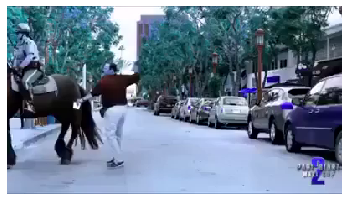

In [14]:
plt.imshow(frames[0], interpolation="nearest")
plt.axis("off")
plt.show()

In [15]:
m = tf.keras.Sequential(
    [
        hub.KerasLayer(
            "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
            trainable=False,
        ),
    ]
)
# m.build([None, expect_img_size, expect_img_size, 3])  # Batch input shape.
m.build([None, 600, 600, 3])  # Batch input shape.

In [16]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2560)              64097680  
                                                                 
Total params: 64,097,680
Trainable params: 0
Non-trainable params: 64,097,680
_________________________________________________________________


In [17]:
def extract_features_from_video_frames(video_name):
    representative_frames = extract_frames_from_video(video_name)
    representative_frames = representative_frames / 255
    resized_frames = tf.image.resize_with_crop_or_pad(representative_frames, 600, 600)
    frames_features = m.predict(resized_frames)
    return frames_features

In [18]:
features = extract_features_from_video_frames(working_video_names[0])

In [19]:
features.shape

(15, 2560)

In [20]:
features_path = os.path.dirname(os.getcwd()) + '/Data/video_frame_features/'
np.save(features_path + working_video_names[0], features)

In [21]:
def save_features_from_video_frames(video_name):
    representative_frames = extract_frames_from_video(video_name)
    representative_frames = representative_frames / 255
    resized_frames = tf.image.resize_with_crop_or_pad(representative_frames, 600, 600)
    frames_features = m.predict(resized_frames)

    features_path = os.path.dirname(os.getcwd()) + '/Data/video_frame_features/'
    np.save(features_path + video_name, frames_features)

In [22]:
from tqdm import tqdm

In [23]:
_, _, features_files = next(os.walk(features_path))

In [24]:
features_files = [x[:-4] for x in features_files]

In [25]:
print(features_files)

['rw9h_574HxE_59_66', '6r5DmFa5ZR8_51_58', 'nHZsE7T7hwI_13_23', 'j2Dhf-xFUxU_20_29', 'q3I3R_gqy8M_34_37', 'BVjvRpmHg0w_231_250', 'n_Z0-giaspE_168_193', 'uxEhH6MPH28_69_85', 'ACOmKiJDkA4_75_81', 'NUYu9c9XsgY_7_21', 'MWvCcwTw7Ac_78_86', 'ZDoy9S82ETA_5_15', 'uVPnDJKt1M0_0_6', 'FeTaKOPVaJg_60_70', '2FLsMPsywRc_45_63', 'YS1mzzhmWWA_9_16', 'HM-ZDoRWiH4_0_5', 'hJFBXHtxKIc_286_291', 'F3pmw2ga244_59_65', '2YhDTpzxd3c_166_170', 'X6uJyuD_Zso_3_17', 'uO7Eysrs8_k_106_114', 'm7x8uIdg2XU_67_73', 'R2DvpPTfl-E_20_25', '0lh_UWF9ZP4_103_110', 'qIk_Dz5XE5E_104_109', 'x68Djm_Q0GA_0_10', 'lc9bA-hvqHU_1_6', '6t0BpjwYKco_230_240', 'g36ho6UrBz0_5_20', 'ZbzDGXEwtGc_6_15', 'buJ5HDCinrM_150_166', '04Gt01vatkk_248_265', 'jbzaMtPYtl8_48_58', 'mv89psg6zh4_33_46', 'ljGcQocjSs4_38_60', 'ByGspTdA1ug_16_24', 'M_TP6UTrh30_343_358', 'mFCf8lLXrUc_25_35', '8mSUD7JGNO0_174_181', 'E2r6nnkwl0c_6_18', 'n2NLoLNecgI_168_178', 'rQuNYxNmA6M_0_4', 'n016q1w8Q30_2_11', '6q1dX6thX3E_286_295', '6eokrw6_bjU_1_9', 'Ms3QdGIzltU_1_16', '6t0

In [26]:
len(features_files)

1971

In [27]:
unprocessed_video_names = []

In [28]:
for i in tqdm(range(len(working_video_names))):
    if(working_video_names[i] not in features_files):
        try:
            save_features_from_video_frames(working_video_names[i])
            features_files.append(working_video_names[i])
        except:
            unprocessed_video_names.append(working_video_names[i])
            continue

100%|██████████| 1971/1971 [00:00<00:00, 52283.24it/s]


In [29]:
# nV3Wv8iHp4U_0_38
# 0piwbTivpDg_10_40
# eiyuac7hA4A_4_47
# JntMAcTlOF0_50_70
# QzulzuWr0Zw_20_45
# vulNlhUI6m0_7_27
# q8t7iSGAKik_57_74

# Load captions

In [30]:
captions_path = os.path.dirname(os.getcwd()) + '/Data/AllVideoDescriptions.txt'

In [31]:
with open(captions_path, 'r') as file:
    captions = file.readlines()

In [32]:
del captions[:7]

In [33]:
captions[:2]

['-4wsuPCjDBc_5_15 a squirrel is eating a peanut in it s shell\n',
 '-4wsuPCjDBc_5_15 a chipmunk     is eating\n']

In [34]:
' '.join(captions[1].split()[1:])

'a chipmunk is eating'

In [35]:
video_id, video_description = [], []

In [36]:
for i, cap in enumerate(captions):
    video_id.append(captions[i].split()[0])
    video_description.append(' '.join(captions[i].split()[1:]))

In [37]:
captions_dic = {'videoID': video_id, 'videoDescription': video_description}

In [38]:
captions_df = pd.DataFrame(captions_dic)

In [39]:
captions_df.head()

,videoID,videoDescription
0,-4wsuPCjDBc_5_15,a squirrel is eating a peanut in it s shell
1,-4wsuPCjDBc_5_15,a chipmunk is eating
2,-4wsuPCjDBc_5_15,a chipmunk is eating a peanut
3,-4wsuPCjDBc_5_15,a chipmunk is eating a nut
4,-4wsuPCjDBc_5_15,a squirrel is eating a nut


In [110]:
captions_df[captions_df['videoID']=='d']

,videoID,videoDescription,Description_length,Number_of_frames
80827,d,"[the, horse]",2,NaN


In [41]:
# The length of captions in words
captions_df["videoDescription"].str.split().str.len().describe()

count    80828.000000
mean         7.025734
std          2.810604
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         45.000000
Name: videoDescription, dtype: float64

### Only keep captions for videos present in training data

In [42]:
len(captions_df["videoID"].unique())

1971

In [43]:
from pathlib import Path

In [44]:
def check_if_video_exists(video_name):
    video_path = os.path.dirname(os.getcwd()) + '/Data/video_frame_features/' + video_name + ".npy"
    my_file = Path(video_path)
    
    if my_file.is_file():
        return True
    else:
        return False

In [45]:
captions_df = captions_df[captions_df["videoID"].apply(check_if_video_exists)]

In [46]:
len(captions_df)

80828

# Tokenize the captions

In [47]:
captions_df["videoDescription"].iloc[0]

'a squirrel is eating a peanut in it s shell'

In [48]:
# remove punctuation from the captions, all symbols to lowercase, split the caption into words
captions_df["videoDescription"] = (
    captions_df["videoDescription"]
    .str.replace(r"<br\s*/?>", r" ")
    .str.lower()
    .str.replace(r"[^a-zA-Z']", r" ")
    .str.split()
)

In [49]:
captions_df["videoDescription"].head()

0    [a, squirrel, is, eating, a, peanut, in, it, s...
1                            [a, chipmunk, is, eating]
2                 [a, chipmunk, is, eating, a, peanut]
3                    [a, chipmunk, is, eating, a, nut]
4                    [a, squirrel, is, eating, a, nut]
Name: videoDescription, dtype: object

In [50]:
captions_df["Description_length"] = captions_df["videoDescription"].map(len)

In [51]:
captions_df["videoDescription"].values

array([list(['a', 'squirrel', 'is', 'eating', 'a', 'peanut', 'in', 'it', 's', 'shell']),
       list(['a', 'chipmunk', 'is', 'eating']),
       list(['a', 'chipmunk', 'is', 'eating', 'a', 'peanut']), ...,
       list(['a', 'young', 'child', 'is', 'using', 'an', 'exercise', 'machine']),
       list(['the', 'boy', 'is', 'exercising']), list(['the', 'horse'])],
      dtype=object)

In [52]:
captions_df.head()

,videoID,videoDescription,Description_length
0,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, peanut, in, it, s...",10
1,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating]",4
2,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, peanut]",6
3,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, nut]",6
4,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, nut]",6


In [53]:
word_array = np.concatenate(captions_df["videoDescription"].values)

In [54]:
len(word_array)

567676

In [55]:
from collections import Counter
vocabulary = Counter()

In [56]:
vocabulary.update(word_array)

In [57]:
vocabulary.most_common()[:10]

[('a', 90402),
 ('is', 44518),
 ('the', 29204),
 ('man', 23161),
 ('woman', 10174),
 ('on', 9428),
 ('in', 9230),
 ('playing', 7804),
 ('are', 7138),
 ('of', 6713)]

In [58]:
len(vocabulary)

12503

In [59]:
# only keep a word if the word appeared more than once
truncated_vocabulary = {k: v for (k, v) in vocabulary.items() if v > 1}

In [60]:
vocab_size = len(truncated_vocabulary)
vocab_size

7016

In [61]:
# dictionary for encoding words into ids
# do i need <unk> token or oob_ will cover the need?
word_to_id = {word: id_ + 3 for id_, word in enumerate(truncated_vocabulary)}
for id_, token in enumerate(("<pad>", "<bos>", "<eos>")):
    word_to_id[token] = id_

In [62]:
caption_example = captions_df["videoDescription"].iloc[0]
caption_example

['a', 'squirrel', 'is', 'eating', 'a', 'peanut', 'in', 'it', 's', 'shell']

In [63]:
for word in caption_example:
    print(word_to_id.get(word) or vocab_size)

3
4
5
6
3
7
8
9
10
11


In [64]:
# dictionary for decoding
id_to_word = {id_: word for word, id_ in word_to_id.items()}

In [65]:
encoded_caption_example = [word_to_id[word] for word in caption_example]
encoded_caption_example

[3, 4, 5, 6, 3, 7, 8, 9, 10, 11]

In [66]:
[id_to_word[id_] for id_ in encoded_caption_example]

['a', 'squirrel', 'is', 'eating', 'a', 'peanut', 'in', 'it', 's', 'shell']

In [67]:
words = tf.constant(list(id_to_word.values()))
word_ids = tf.constant(list(word_to_id.values()), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [68]:
table.size()

<tf.Tensor: shape=(), dtype=int64, numpy=7020>

In [69]:
vocab_size = len(words)

In [70]:
vocab_size

7019

In [71]:
caption_example

['a', 'squirrel', 'is', 'eating', 'a', 'peanut', 'in', 'it', 's', 'shell']

In [72]:
table.lookup(tf.constant(caption_example))

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 3,  4,  5,  6,  3,  7,  8,  9, 10, 11])>

In [73]:
def encode_words_to_id(word_list):
    return table.lookup(tf.constant(word_list))

## GloVe Embeddings

In [74]:
path_to_glove_file = os.path.dirname(os.getcwd()) + '/Data/glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as glove_file:
    for line in tqdm(glove_file):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype="f", sep=" ")
        embeddings_index[word] = coefs

400000it [00:21, 18709.22it/s]


In [75]:
embed_size = 300
hits = 0
misses = 0

# Prepare embedding matrix
# initialize it randomly with values from -1 to 1
embedding_matrix = (np.random.rand(vocab_size + num_oov_buckets, embed_size) * 2) - 1 
for word, i in word_to_id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6543 words (476 misses)


In [76]:
embedding_layer = keras.layers.Embedding(
    vocab_size + num_oov_buckets,
    embed_size,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
    name="caption_embedding",
)

In [77]:
del embeddings_index

## Subword tokenization

In [78]:
!pip install tokenizers

In [79]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece

In [80]:
# tokenizer = Tokenizer(WordPiece(unk_token="<unk>"))

In [81]:
# vocab_size = 4000

In [82]:
# from tokenizers.trainers import WordPieceTrainer

# trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=["<pad>", "<bos>", "<eos>", "<unk>"])

In [83]:
# from tokenizers.pre_tokenizers import Whitespace

# tokenizer.pre_tokenizer = Whitespace()

In [84]:
# captions_df["Description"].values

In [85]:
# # remove punctuation from the captions, all symbols to lowercase
# captions_df["Description"] = (
#     captions_df["Description"]
#     .str.replace(r"<br\s*/?>", r" ")
#     .str.lower()
#     .str.replace(r"[^a-zA-Z']", r" ")
#     .values
# )

In [86]:
# tokenizer.train_from_iterator(captions_df["Description"].values, trainer)

In [87]:
# output = tokenizer.encode("the man chops onionsss")

In [88]:
# output.ids

In [89]:
# captions_df["Description_encoded"] = captions_df["Description"].map(
#     lambda x: tokenizer.encode(x).ids
# )

In [90]:
# captions_df["Description_encoded_length"] = captions_df["Description_encoded"].map(len)

# Prepare data for the model

In [91]:
captions_df.head()

,videoID,videoDescription,Description_length
0,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, peanut, in, it, s...",10
1,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating]",4
2,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, peanut]",6
3,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, nut]",6
4,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, nut]",6


In [92]:
def get_padded_data(caption_index):
    video_name = captions_df["videoID"].iloc[caption_index]

    stored_features_path = os.path.dirname(os.getcwd()) + '/Data/video_frame_features/' + video_name + ".npy"
    features_array = np.load(stored_features_path)
    video_features_shape = features_array.shape

    input_cnn_padding_length = captions_df["Description_length"].iloc[caption_index] + 1 # 1 for oov 
    input_cnn_padding_array = np.full([input_cnn_padding_length, 2560], 0)
    input_cnn_padded_array = np.concatenate((features_array, input_cnn_padding_array))

    list_first_half = video_features_shape[0] * ["<pad>"]

    input_sequence_caption = list_first_half + ["<bos>"] + captions_df["videoDescription"].iloc[caption_index]
    target_sequence_caption = list_first_half + captions_df["videoDescription"].iloc[caption_index] + ["<eos>"]
    
    return [input_cnn_padded_array, input_sequence_caption], target_sequence_caption

In [93]:
[input_cnn, input_caption], target_caption = get_padded_data(1)

In [94]:
print(len(input_cnn))
print(len(input_caption))
print(len(target_caption))

16
16
16


In [95]:
input_cnn.shape

(16, 2560)

In [96]:
target_caption

['<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'a',
 'chipmunk',
 'is',
 'eating',
 '<eos>']

In [97]:
input_caption

['<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<bos>',
 'a',
 'chipmunk',
 'is',
 'eating']

In [98]:
video_name_list = []
number_of_frames_list = []

In [99]:
video_features_path = os.path.dirname(os.getcwd()) + '/Data/video_frame_features/'
video_features_path

'/content/drive/My Drive/ITI_Graduation_Project/Video_Captioning/Data/video_frame_features/'

In [100]:
_, _, filenames = next(os.walk(video_features_path))

In [101]:
filenames[:2]

['rw9h_574HxE_59_66.npy', '6r5DmFa5ZR8_51_58.npy']

In [112]:
# # after the first time, it may be faster to load the computed dict
# for filename in filenames:
#     np_path = video_features_path + filename
#     video_name_list.append(filename[:-4])
#     number_of_frames = np.load(np_path).shape[0]
#     number_of_frames_list.append(number_of_frames)

# video_frames_dict = dict(zip(video_name_list, number_of_frames_list))

In [113]:
import pickle
# with open('video_frames_dict.pickle', 'wb') as handle:
#     pickle.dump(video_frames_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [114]:
with open(os.path.dirname(os.getcwd()) + '/Data/video_frames_dict.pickle', "rb") as handle:
    video_frames_dict = pickle.load(handle)

In [115]:
captions_df["Number_of_frames"] = captions_df["videoID"].map(video_frames_dict)

In [116]:
captions_df.head()

,videoID,videoDescription,Description_length,Number_of_frames
0,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, peanut, in, it, s...",10,11
1,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating]",4,11
2,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, peanut]",6,11
3,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, nut]",6,11
4,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, nut]",6,11


In [117]:
def padding_part_of_caption_sequence(video_length):
    return video_length * ["<pad>"]

def append_bos_token(sequence_list):
    return sequence_list + ["<bos>"]

def append_eos_token(sequence_list):
    return sequence_list + ["<eos>"]


In [118]:
# create padded caption to use as input, with <bos> token
captions_df["input_sequence_caption"] = captions_df["Number_of_frames"]\
                                        .apply(padding_part_of_caption_sequence) \
                                        .apply(append_bos_token) + captions_df["videoDescription"]

In [119]:
# create padded caption to use as target, with <eos> token
captions_df["target_sequence_caption"] = captions_df["Number_of_frames"]\
                                        .apply(padding_part_of_caption_sequence) + captions_df["videoDescription"]\
                                        .apply(append_eos_token)

In [120]:
captions_df.head()

,videoID,videoDescription,Description_length,Number_of_frames,input_sequence_caption,target_sequence_caption
0,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, peanut, in, it, s...",10,11,"[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...","[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa..."
1,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating]",4,11,"[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...","[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa..."
2,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, peanut]",6,11,"[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...","[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa..."
3,-4wsuPCjDBc_5_15,"[a, chipmunk, is, eating, a, nut]",6,11,"[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...","[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa..."
4,-4wsuPCjDBc_5_15,"[a, squirrel, is, eating, a, nut]",6,11,"[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...","[<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa..."


In [121]:
# convert caption sequences from list to numpy arrays
captions_df["input_sequence_caption"] = captions_df["input_sequence_caption"].apply(lambda x: np.array(x))
captions_df["target_sequence_caption"] = captions_df["target_sequence_caption"].apply(lambda x: np.array(x))

## Create data loading pipeline

In [122]:
# training-validation split is about 80-20
train_size = 64660

In [123]:
# features = ['input_sequence_caption', 'videoID', 'target_sequence_caption', 'Description_length']
training_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.ragged.constant(
            captions_df["input_sequence_caption"].iloc[:train_size].values
        ),
        tf.ragged.constant(
            captions_df["target_sequence_caption"].iloc[:train_size].values
        ),
        tf.ragged.constant(captions_df["videoID"].iloc[:train_size].values),
        tf.ragged.constant(captions_df["Description_length"].iloc[:train_size].values)
    )
)

In [124]:
# word tokenization
subsample_rate = 1

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (
        tf.ragged.constant(
            captions_df["input_sequence_caption"]
            .iloc[train_size::subsample_rate]
            .values
        ),
        tf.ragged.constant(
            captions_df["target_sequence_caption"]
            .iloc[train_size::subsample_rate]
            .values
        ),
        tf.ragged.constant(
            captions_df["videoID"].iloc[train_size::subsample_rate].values
        ),
        tf.ragged.constant(
            captions_df["Description_length"].iloc[train_size::subsample_rate].values
        ),
    )
)

In [125]:
captions_df["input_sequence_caption"].map(len).describe()

count    80828.000000
mean        19.084562
std          7.168992
min          5.000000
25%         14.000000
50%         17.000000
75%         22.000000
max         77.000000
Name: input_sequence_caption, dtype: float64

In [126]:
# load video features array and pad it, return padded tensor
def get_padded_input_cnn(video_name_tensor, caption_length_tensor):
    stored_features_path = (os.path.dirname(os.getcwd()) + '/Data/video_frame_features/'
                           + video_name_tensor.numpy().decode("ascii") + ".npy")
    features_array = np.load(stored_features_path)
    
    input_cnn_padding_length = caption_length_tensor + 1
    input_cnn_padding_array = np.full([input_cnn_padding_length, 2560], 0)
    input_cnn_padded_array = np.concatenate((features_array, input_cnn_padding_array))
    return tf.constant(input_cnn_padded_array)

In [127]:
for input_seq, target_seq, video_name, caption_length in training_dataset.take(1):
    print(get_padded_input_cnn(video_name, caption_length))

tf.Tensor(
[[-0.11117487  0.06839966  0.17292647 ... -0.10178041 -0.17901552
   0.02943783]
 [-0.18497968 -0.01959665  0.39815918 ... -0.1342386  -0.06737049
  -0.02983496]
 [-0.07405843 -0.05438354  0.4044995  ... -0.11281164 -0.08659064
  -0.0481674 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(22, 2560), dtype=float64)


In [128]:
def get_padded_input_cnn_batch(input_seq_batch, target_seq_batch, video_name_batch_tensor):
    max_length = input_seq_batch.shape[1]
    batch_size = input_seq_batch.shape[0]
    input_cnn_padded_batch_array = np.empty((batch_size, max_length, 2560))

    for ind, video_name_tensor in enumerate(video_name_batch_tensor):
        # get_padded_input_cnn(video_name_tensor, caption_length_tensor)
        stored_features_path = stored_features_path = (os.path.dirname(os.getcwd()) + '/Data/video_frame_features/'
                               + video_name_tensor.numpy().decode("ascii") + ".npy")
        features_array = np.load(stored_features_path)

        needed_padding_length = max_length - features_array.shape[0]
        # input_cnn_padding_length = caption_length_tensor + 1
        input_cnn_padding_array = np.full([needed_padding_length, 2560], 0)
        input_cnn_padded_array = np.concatenate((features_array, input_cnn_padding_array))
        input_cnn_padded_batch_array[ind] = input_cnn_padded_array

    return tf.constant(input_cnn_padded_batch_array)

In [129]:
for input_seq, target_seq, video_name, caption_length in (
    training_dataset.shuffle(buffer_size=200)
    .map(
        lambda input_seq, target_seq, video_name, caption_length: [
            table.lookup(input_seq),
            table.lookup(target_seq),
            video_name,
            caption_length,
        ]
    )
    .padded_batch(2) # make batches with batch_size 2 with padding_value 0 
    .prefetch(1)
    .take(1)
):
    print(
        input_seq,
        target_seq,
        video_name,
        caption_length,
        get_padded_input_cnn_batch(input_seq, target_seq, video_name),
    )

tf.Tensor(
[[  0   0   0   0   0   0   0   0   1   3  32  67   3 111 144   3 146]
 [  0   0   0   0   0   0   1   3 174   5 183 186  46   3 187   0   0]], shape=(2, 17), dtype=int64) tf.Tensor(
[[  0   0   0   0   0   0   0   0   3  32  67   3 111 144   3 146   2]
 [  0   0   0   0   0   0   3 174   5 183 186  46   3 187   2   0   0]], shape=(2, 17), dtype=int64) tf.Tensor([b'-8y1Q0rA3n8_95_102' b'-9CUm-2cui8_39_44'], shape=(2,), dtype=string) tf.Tensor([8 8], shape=(2,), dtype=int64) tf.Tensor(
[[[ 0.14952895 -0.11789537 -0.11501838 ...  0.08997658 -0.15782854
   -0.15006199]
  [ 0.08918436 -0.09734034 -0.18947677 ... -0.21668901 -0.05263512
    0.03533698]
  [-0.0106496   0.31457353  0.02008102 ... -0.18700926 -0.18083969
   -0.03805826]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.05880203  0

In [130]:
def element_length_fn(input_seq, target_seq, video_name, caption_length):
    return tf.shape(input_seq)[0]

In [131]:
shuffle_buffer_size = train_size
batch_size = 24

In [132]:
# word tokenization
training_dataset = training_dataset.shuffle(shuffle_buffer_size)
training_dataset = training_dataset.map(
        lambda input_seq, target_seq, video_name, caption_length: [
            table.lookup(input_seq),
            table.lookup(target_seq),
            video_name,
            caption_length,
        ]
    )

training_dataset = training_dataset.apply(
    tf.data.experimental.bucket_by_sequence_length(
        element_length_func=element_length_fn,
        bucket_batch_sizes=[
            batch_size,
            batch_size,
            batch_size,
            batch_size,
            batch_size,
            batch_size,
            batch_size,
        ],
        bucket_boundaries=[11, 15, 19, 25, 35, 50],
    )
)
# ValueError: if len(bucket_batch_sizes) != len(bucket_boundaries) + 1.

training_dataset = training_dataset.map(
    lambda input_seq_batch, target_seq_batch, video_name_batch, caption_length_batch: [
        (
            (
                tf.py_function(
                    func=get_padded_input_cnn_batch,
                    inp=[input_seq_batch, target_seq_batch, video_name_batch],
                    Tout=tf.float64,
                )
            ),
            input_seq_batch,
        ),
        target_seq_batch,
    ]
)

training_dataset = training_dataset.prefetch(1)

Instructions for updating:
Use `tf.data.Dataset.bucket_by_sequence_length(...)`.


Instructions for updating:
Use `tf.data.Dataset.bucket_by_sequence_length(...)`.


In [133]:
for (input_cnn_batch, input_seq), target_seq in training_dataset.take(2):
    print(input_cnn_batch.shape)
    print(input_seq.shape)
    print(target_seq.shape)

(24, 18, 2560)
(24, 18)
(24, 18)
(24, 14, 2560)
(24, 14)
(24, 14)


In [134]:
# cntr = 0
# for (input_cnn_batch, input_seq), target_seq in training_dataset:
#     cntr += 1
# print(cntr) # 2698

In [135]:
for (input_cnn_padded_tensor, input_seq), target_seq in training_dataset.take(1):
    print(input_cnn_padded_tensor, input_seq, target_seq)

tf.Tensor(
[[[-0.08078546 -0.05463688 -0.13008049 ... -0.02223761 -0.17153698
   -0.16320221]
  [-0.10476261 -0.0541045  -0.09685024 ... -0.00263551 -0.19486853
   -0.14688541]
  [-0.10690735 -0.05218519 -0.13980871 ... -0.01966505 -0.18993637
   -0.14105095]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.10836007  0.14467762 -0.13828944 ... -0.04104912 -0.10230144
   -0.00617703]
  [-0.06799781  0.17128147 -0.19039199 ...  0.01346708 -0.07039545
    0.05146312]
  [-0.10759816  0.09611279 -0.15709995 ...  0.00772683 -0.07717092
    0.00344155]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.09477262 -0.1217367

In [136]:
2698 * 24 - 64660

92

In [137]:
# word tokenization

batch_size_val = 24

validation_dataset = validation_dataset.map(
    lambda input_seq, target_seq, video_name, caption_length: [
        table.lookup(input_seq),
        table.lookup(target_seq),
        video_name,
        caption_length
    ]
)

validation_dataset = validation_dataset.apply(
    tf.data.experimental.bucket_by_sequence_length(
        element_length_func=element_length_fn,
        bucket_batch_sizes=[
            batch_size_val,
            batch_size_val,
            batch_size_val,
            batch_size_val,
            batch_size_val,
            batch_size_val,
            batch_size_val,
        ],
        bucket_boundaries=[11, 15, 19, 25, 35, 50],
    )
)
validation_dataset = validation_dataset.map(
    lambda input_seq_batch, target_seq_batch, video_name_batch, caption_length_batch: [
        (
            (
                tf.py_function(
                    func=get_padded_input_cnn_batch,
                    inp=[input_seq_batch, target_seq_batch, video_name_batch],
                    Tout=tf.float64,
                )
            ),
            input_seq_batch,
        ),
        target_seq_batch,
    ]
)
validation_dataset = validation_dataset.prefetch(1)

In [138]:
for (input_cnn_padded_tensor, input_seq), target_seq in validation_dataset.take(1):
    print(input_cnn_padded_tensor, input_seq, target_seq)

tf.Tensor(
[[[-0.1001879   0.01041345 -0.15408836 ... -0.15341873  0.00107785
   -0.14697173]
  [-0.05793521  0.01640865 -0.14478444 ... -0.15606891 -0.01019466
   -0.11403552]
  [-0.01615247  0.03373709 -0.14845781 ... -0.17059088 -0.00939417
   -0.10958876]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.1001879   0.01041345 -0.15408836 ... -0.15341873  0.00107785
   -0.14697173]
  [-0.05793521  0.01640865 -0.14478444 ... -0.15606891 -0.01019466
   -0.11403552]
  [-0.01615247  0.03373709 -0.14845781 ... -0.17059088 -0.00939417
   -0.10958876]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.1001879   0.0104134

# Create the model

In [139]:
lstm_size = 1000
cnn_embed_size = 500

In [140]:
input_cnn = keras.layers.Input(shape=[None, 2560], dtype=tf.float64, name="input_cnn")
input_caption = keras.layers.Input(shape=[None], dtype=tf.int64, name="teacher_forcing")

cnn_embedding = keras.layers.TimeDistributed(
                keras.layers.Dense(cnn_embed_size, activation=None), name="cnn_embedding")(input_cnn)  
# cnn_embedding shape is ([None, None, 500])

lstm_1 = keras.layers.LSTM(lstm_size, return_sequences=True, name="lstm_1")
lstm_1_outputs = lstm_1(cnn_embedding)

mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0), name="mask")(input_caption)

caption_embedding = embedding_layer(input_caption)
concat = keras.layers.concatenate([lstm_1_outputs, caption_embedding])

lstm_2_outputs = keras.layers.LSTM(lstm_size, return_sequences=True, name="lstm_2")\
                 (concat, mask=mask) # return_state = True

output = keras.layers.TimeDistributed(
         keras.layers.Dense(vocab_size + num_oov_buckets, activation="softmax"), name="output")\
         (lstm_2_outputs, mask=mask)

model = keras.Model(inputs=[input_cnn, input_caption], outputs=[output])

In [141]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_cnn (InputLayer)         [(None, None, 2560)  0           []                               
                                ]                                                                 
                                                                                                  
 cnn_embedding (TimeDistributed  (None, None, 500)   1280500     ['input_cnn[0][0]']              
 )                                                                                                
                                                                                                  
 teacher_forcing (InputLayer)   [(None, None)]       0           []                               
                                                                                              

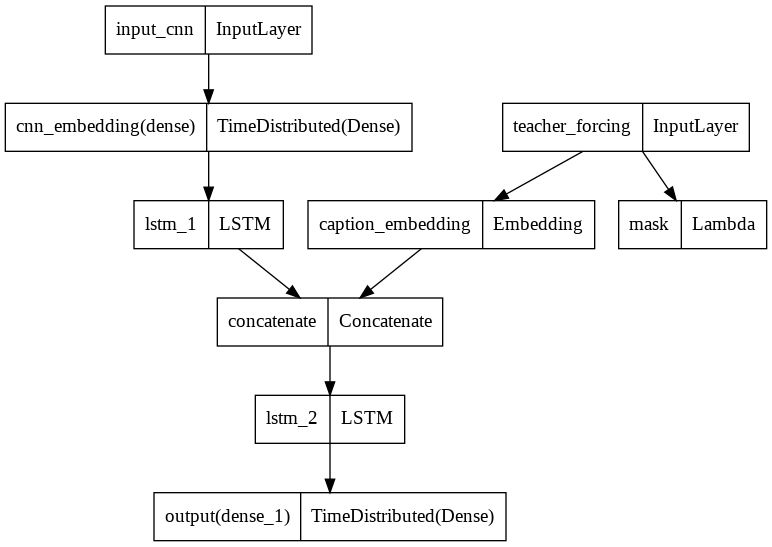

In [142]:
tf.keras.utils.plot_model(model)

# Train the model

In [143]:
# optimizer = keras.optimizers.Adam()
# model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'], optimizer=optimizer)

In [144]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5", save_best_only=True)
# # early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [145]:
# history = model.fit(training_dataset, epochs=1,
#                     callbacks = [checkpoint_cb], validation_data = validation_dataset)

In [146]:
# model.evaluate(validation_dataset)

In [147]:
# 2698 * 24 - 64660

In [148]:
# Stop

In [149]:
# model.save_weights(os.path.dirname(os.getcwd()) + '/saved_model/weights')

In [150]:
# model.save(os.path.dirname(os.getcwd()) + '/saved_model/whole_model')

In [151]:
# bucketize batches, so that batches have inputs of similar length, so that there's less less padding

In [152]:
# history.history["loss"]

In [153]:
model = keras.models.load_model(os.path.dirname(os.getcwd()) + '/saved_model/whole_model')

In [154]:
# model.evaluate(validation_dataset)

# Inference

In [155]:
captions_df[
    [
        "input_sequence_caption",
        "target_sequence_caption",
        "videoID",
        "Description_length",
    ]
].iloc[train_size + 700]

input_sequence_caption     [<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...
target_sequence_caption    [<pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pa...
videoID                                                     nULE40HEWpA_5_11
Description_length                                                         7
Name: 65360, dtype: object

In [156]:
captions_df["input_sequence_caption"].iloc[train_size + 700]

array(['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<bos>', 'a', 'person', 'playing', 'with', 'baby', 'foster',
       'kitten'], dtype='<U7')

In [157]:
table.lookup(tf.constant(captions_df["target_sequence_caption"].iloc[train_size + 700]))

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    3,  120,   33,   67,
        375, 7019, 1670,    2])>

In [158]:
captions_df["videoID"].iloc[train_size + 700]

'nULE40HEWpA_5_11'

In [159]:
captions_df["Description_length"].iloc[train_size + 700]

7

In [160]:
sample_cnn_input = get_padded_input_cnn(
    tf.constant(captions_df["videoID"].iloc[train_size + 700]),
    tf.constant((captions_df["Description_length"].iloc[train_size + 700])),
)
sample_cnn_input

<tf.Tensor: shape=(15, 2560), dtype=float64, numpy=
array([[-0.15763436, -0.05479944,  0.33643076, ..., -0.08619007,
         0.10388517,  0.34580061],
       [-0.16848283, -0.03822588,  0.27931499, ..., -0.13375084,
         0.22154848,  0.2616536 ],
       [-0.12738691,  0.02357914,  0.30063182, ..., -0.06468941,
         0.04390705,  0.59383929],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])>

In [161]:
tf.expand_dims(sample_cnn_input, axis=0)

<tf.Tensor: shape=(1, 15, 2560), dtype=float64, numpy=
array([[[-0.15763436, -0.05479944,  0.33643076, ..., -0.08619007,
          0.10388517,  0.34580061],
        [-0.16848283, -0.03822588,  0.27931499, ..., -0.13375084,
          0.22154848,  0.2616536 ],
        [-0.12738691,  0.02357914,  0.30063182, ..., -0.06468941,
          0.04390705,  0.59383929],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])>

In [162]:
sample_seq_input = table.lookup(tf.constant(captions_df["input_sequence_caption"].iloc[train_size + 700]))
sample_seq_input

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    1,    3,  120,   33,
         67,  375, 7019, 1670])>

In [163]:
# 1 we feed the model expected output at previous time steps
sample_prediction = model.predict((tf.expand_dims(sample_cnn_input, axis=0),
                                   tf.expand_dims(sample_seq_input, axis=0)))

In [164]:
sample_prediction.shape

(1, 15, 7020)

In [165]:
np.argmax(sample_prediction, axis=2).tolist()

[[818, 818, 818, 818, 818, 818, 818, 3, 120, 5, 67, 21, 2, 2, 2]]

In [166]:
[id_to_word[id_] for id_ in np.argmax(sample_prediction, axis=2).tolist()[0]]

['pretty',
 'pretty',
 'pretty',
 'pretty',
 'pretty',
 'pretty',
 'pretty',
 'a',
 'person',
 'is',
 'with',
 'an',
 '<eos>',
 '<eos>',
 '<eos>']

In [167]:
# 2 we first feed the cnn_inputs, then <bos> token, then its own output at the previous step

In [168]:
sample_seq_input = table.lookup(tf.constant(captions_df["input_sequence_caption"].iloc[train_size + 700]))
sample_seq_input

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    1,    3,  120,   33,
         67,  375, 7019, 1670])>

In [169]:
# add a lot of padding to the cnn input, so that there's enough padding until the model outputs <eos> token
sample_cnn_input_unlim = get_padded_input_cnn(tf.constant(captions_df["videoID"].iloc[train_size + 700]),
                                              tf.constant(20))
sample_cnn_input_unlim

<tf.Tensor: shape=(28, 2560), dtype=float64, numpy=
array([[-0.15763436, -0.05479944,  0.33643076, ..., -0.08619007,
         0.10388517,  0.34580061],
       [-0.16848283, -0.03822588,  0.27931499, ..., -0.13375084,
         0.22154848,  0.2616536 ],
       [-0.12738691,  0.02357914,  0.30063182, ..., -0.06468941,
         0.04390705,  0.59383929],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])>

In [170]:
captions_df["Number_of_frames"].iloc[train_size + 700]

7

In [171]:
table.lookup(
    tf.constant(
        append_bos_token(
            padding_part_of_caption_sequence(
                captions_df["Number_of_frames"].iloc[train_size + 700]
            )
        )
    )
)

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 1])>

In [172]:
input_seq = table.lookup(
    tf.constant(
        append_bos_token(
            padding_part_of_caption_sequence(
                captions_df["Number_of_frames"].iloc[train_size + 700]
            )
        )
    )
)
input_seq

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 1])>

In [173]:
one_step_prediction = model.predict(
    (
        tf.expand_dims(sample_cnn_input_unlim[:8], axis=0),
        tf.expand_dims(input_seq, axis=0),
    )
)

In [174]:
one_step_prediction.shape

(1, 8, 7020)

In [175]:
np.argmax(one_step_prediction, axis=2)

array([[818, 818, 818, 818, 818, 818, 818,   3]])

In [176]:
next_predicted_token = np.argmax(one_step_prediction, axis=2)[0][-1]
next_predicted_token

3

In [177]:
next_predicted_token = tf.cast(tf.constant([next_predicted_token]), tf.int32)
next_predicted_token

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>

In [178]:
input_seq = tf.cast(input_seq, tf.int32)
input_seq

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)>

In [179]:
input_seq_with_new = tf.concat([input_seq, next_predicted_token], axis=-1)
input_seq_with_new

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 1, 3], dtype=int32)>

In [180]:
one_more_step_prediction = model.predict(
    (
        tf.expand_dims(sample_cnn_input_unlim[:9], axis=0),
        tf.expand_dims(input_seq_with_new, axis=0),
    )
)

In [181]:
one_more_step_prediction.shape

(1, 9, 7020)

In [182]:
np.argmax(one_more_step_prediction, axis=2)[0][-1]

120

In [183]:
id_to_word[120]

'person'

In [191]:
sample_cnn_input_unlim = get_padded_input_cnn(tf.constant(captions_df["videoID"].iloc[train_size + 16167]), tf.constant(20))
sample_cnn_input_unlim

<tf.Tensor: shape=(25, 2560), dtype=float64, numpy=
array([[ 0.10988455,  0.06094956,  0.01485856, ...,  0.00715958,
         0.13651444, -0.07547254],
       [ 0.1241137 ,  0.04908846,  0.11177714, ..., -0.00231136,
         0.13425285,  0.02523544],
       [ 0.05693436,  0.22515042,  0.03359358, ..., -0.04174967,
         0.17058238,  0.3059245 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])>

In [192]:
input_seq = table.lookup(
    tf.constant(
        append_bos_token(
            padding_part_of_caption_sequence(
                captions_df["Number_of_frames"].iloc[train_size + 16167]
            )
        )
    )
)

initial_input_seq_length = len(input_seq)
END_TOKEN = 2

next_token = -1
for i in range(20):
    next_token = model.predict(
        (
            tf.expand_dims(sample_cnn_input_unlim[: len(input_seq)], axis=0),
            tf.expand_dims(input_seq, axis=0),
        )
    )[0][-1].argmax()

    if next_token == END_TOKEN:
        break
    
    input_seq = tf.concat(
        [tf.cast(input_seq, tf.int32), tf.cast(tf.constant([next_token]), tf.int32)],
        axis=-1,
    )

In [193]:
input_seq

<tf.Tensor: shape=(11,), dtype=int32, numpy=
array([   0,    0,    0,    0,    1,    3,   32,    5,  962,   20, 2079],
      dtype=int32)>

In [195]:
[id_to_word[id_] for id_ in input_seq[initial_input_seq_length:].numpy().tolist()]

['a', 'man', 'is', 'riding', 'on', 'horse']

# Beam Search

In [189]:
80827 - 64660

16167

In [190]:
captions_df["videoID"].iloc[train_size + 16167]

'd'

In [194]:
captions_df[captions_df['videoID']=='d'].index

,videoID,videoDescription,Description_length,Number_of_frames,input_sequence_caption,target_sequence_caption
80827,d,"[the, horse]",2,4,"[<pad>, <pad>, <pad>, <pad>, <bos>, the, horse]","[<pad>, <pad>, <pad>, <pad>, the, horse, <eos>]"


In [196]:
id_to_word[len(id_to_word)] = "<unk>"

In [197]:
def add_to_clipboard(text):
    command = "echo " + text.strip() + "| clip"
    os.system(command)

In [198]:
increment_to_try = 16167  # increment_to_try += 30
print(increment_to_try)
print(captions_df["videoID"].iloc[train_size + increment_to_try])
add_to_clipboard(captions_df["videoID"].iloc[train_size + increment_to_try])

16167
d


In [199]:
# with probabilities
beam_width = 10
maximum_caption_length = 10

sample_cnn_input_unlim = get_padded_input_cnn(
    tf.constant(captions_df["videoID"].iloc[train_size + increment_to_try]),
    tf.constant(maximum_caption_length),
)

input_seq = table.lookup(
    tf.constant(
        append_bos_token(
            padding_part_of_caption_sequence(
                captions_df["Number_of_frames"].iloc[train_size + increment_to_try]
            )
        )
    )
)

In [200]:
initial_input_seq_length = len(input_seq)
certainty_lists = [[] for _ in range(beam_width)]
sentences = [input_seq for _ in range(beam_width)]
sentence_probabilities = [1 for _ in range(beam_width)]
END_TOKEN = 2

In [201]:
np.unravel_index([5, 41, 37], (7,6))

(array([0, 6, 6]), array([5, 5, 1]))

In [202]:
for i in range(maximum_caption_length):
    if i == 0:
        prediction = model.predict(
            (
                tf.expand_dims(sample_cnn_input_unlim[: len(input_seq)], axis=0),
                tf.expand_dims(input_seq, axis=0),
            )
        )[0][-1] # last token in sequence probability

        next_tokens = prediction.argsort()[-beam_width:][::-1]
        for j in range(beam_width):
            sentences[j] = tf.concat(
                [
                    tf.cast(sentences[j], tf.int32),
                    tf.cast(tf.constant([next_tokens[j]]), tf.int32),
                ],
                axis=-1,
            )
            sentence_probabilities[j] = (sentence_probabilities[j] * prediction[next_tokens[j]])
            certainty_lists[j].append(prediction[next_tokens[j]])

    if i > 0:
        next_sentences = sentences.copy()
        next_certainty_lists = [[] for _ in range(beam_width)]
        next_token_probabilities = [[] for _ in range(beam_width)]
        next_sentence_probabilities = [[] for _ in range(beam_width)]

        for j in range(beam_width):
            prediction = model.predict(
                (
                    tf.expand_dims(sample_cnn_input_unlim[: len(sentences[j])], axis=0),
                    tf.expand_dims(sentences[j], axis=0),
                )
            )[0][-1]

            next_sentence_probabilities[j] = prediction * sentence_probabilities[j]
            next_token_probabilities[j] = prediction

        # np.dstack make (concat, stack and block)
        indices_of_most_probable_sentences = np.dstack(
            np.unravel_index(
                np.argsort(np.array(next_sentence_probabilities).ravel()),
                (beam_width, vocab_size + num_oov_buckets),
        ))[0][-beam_width:][::-1]   # shape before slice (1, #beam_width * #(vocab_size + num_oov_buckets), # beam_width)

        for k in range(beam_width):
            next_sentence_index = indices_of_most_probable_sentences[k][0]
            next_token_index = indices_of_most_probable_sentences[k][1]
            next_sentences[k] = tf.concat(
                [
                    tf.cast(sentences[next_sentence_index], tf.int32),
                    tf.cast(tf.constant([next_token_index]), tf.int32),
                ],
                axis=-1,
            )

            sentence_probabilities[k] = next_sentence_probabilities[next_sentence_index][next_token_index]

            next_certainty_lists[k] = certainty_lists[next_sentence_index].copy()
            next_certainty_lists[k].append(next_token_probabilities[next_sentence_index][next_token_index])

        sentences = next_sentences
        certainty_lists = next_certainty_lists

In [203]:
sentences[0][initial_input_seq_length:].numpy().tolist()

[25, 120, 5, 961, 962, 2, 2, 2, 2, 2]

In [204]:
for i in range(beam_width):
    try:
        stop_index = sentences[i][initial_input_seq_length:].numpy().tolist().index(END_TOKEN)
        predicted_caption = [id_to_word[id_] for id_ in sentences[i][initial_input_seq_length:]
                            .numpy().tolist()[:stop_index]]
    except:
        predicted_caption = [id_to_word[id_] for id_ in sentences[i][initial_input_seq_length:]
                            .numpy().tolist()]
                            
    print(predicted_caption)
    print("Sentence probability:", sentence_probabilities[i], '\n')

    for word, certainty in zip(predicted_caption, certainty_lists[i]):
        print(word, '\t', certainty)
    print("\n")

['the', 'person', 'is', 'bike', 'riding']
Sentence probability: 0.010920766 

the 	 0.13748637
person 	 0.20852144
is 	 0.9812128
bike 	 0.5440722
riding 	 0.9918418


['people', 'are', 'riding', 'horses']
Sentence probability: 0.006110157 

people 	 0.1249152
are 	 0.8330276
riding 	 0.9194939
horses 	 0.88419807


['people', 'are', 'riding', 'horses']
Sentence probability: 0.005497796 

people 	 0.1249152
are 	 0.8330276
riding 	 0.9194939
horses 	 0.88419807


['people', 'are', 'riding', 'horses']
Sentence probability: 0.0054646814 

people 	 0.1249152
are 	 0.8330276
riding 	 0.9194939
horses 	 0.88419807


['a', 'man', 'is', 'riding', 'a', 'horse']
Sentence probability: 0.0034691712 

a 	 0.38209563
man 	 0.39148942
is 	 0.75456715
riding 	 0.5637054
a 	 0.34969202
horse 	 0.6926443


['a', 'man', 'is', 'riding', 'on', 'a', 'horse']
Sentence probability: 0.003402804 

a 	 0.38209563
man 	 0.39148942
is 	 0.75456715
riding 	 0.5637054
on 	 0.5368455
a 	 0.31444275
horse 	 0.9935589